# Demo de implementación de un algoritmo de  Hormigas (Ant Colony System) para encontrar el mejor camino en un árbol de búsqueda entre NODO INICIAL a un NODO FINAL
Basado en la librería https://github.com/guofei9987/scikit-opt explicada en https://medium.com/@sakamoto2000.kim/ant-colony-optimization-aco-in-the-travel-salesman-problem-tsp-54f83ccd9eff

In [1]:
#@title Instalar librerías
# -@title Instalar Librería (no hace falta)
##!pip install scikit-opt
print("No se instala la librería porque no se necesita")

No se instala la librería porque no se necesita


In [2]:
#@title Cargar librerías
from __future__ import division
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import spatial
import matplotlib as mpl
from matplotlib import cm
import copy
import networkx as nx

##from sko.ACA import ACA_TSP

print("\nLibrerías importadas")


Librerías importadas


**ÁRBOL DE EJEMPLO:**
(hardcodeado para mostarlo)


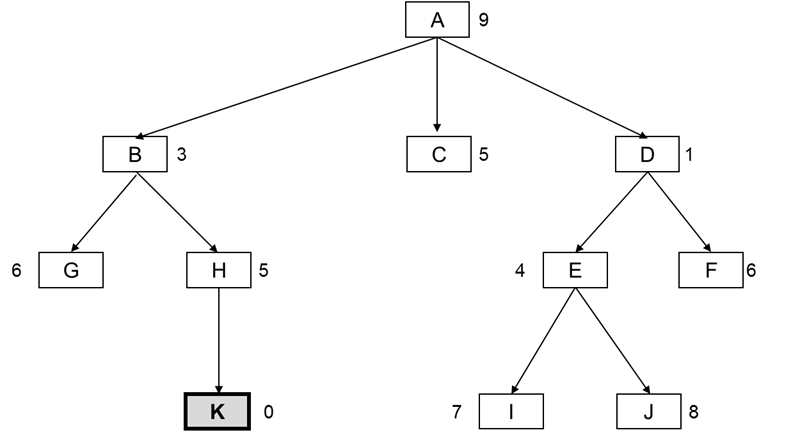

In [3]:
#@title PARAMETRIZACIÓN DEL ÁRBOL DE BÚSQUEDA

usar_arbol = "EJEMPLO" #@param ["EJEMPLO", "AZAR"]
#@markdown Parámetros para Árbol al AZAR:
azar_tipo = "grafo" #@param ["arbol", "grafo"]
azar_criterio_usar_mejor = "azar" #@param ["mayor", "menor", "azar"]
azar_cant_nodos_total = 10 #@param {type:"slider", min:3, max:50, step:1}
azar_cant_nodos_final = 1 #@param {type:"slider", min:1, max:10, step:1}
azar_incluir_costo_transiciones = True #@param {type:"boolean"}

# inicializa las variables
nodosHeuristicas = {}
nodoInicial = None
nodosFinal = []
mayorHeuristicaMejor = True
nodosTransiciones = []

if usar_arbol == "EJEMPLO":
    # indica el valor heurístico de cada nodo
    nodosHeuristicas['A'] = 9
    nodosHeuristicas['B'] = 3
    nodosHeuristicas['C'] = 5
    nodosHeuristicas['D'] = 1
    nodosHeuristicas['E'] = 4
    nodosHeuristicas['F'] = 6
    nodosHeuristicas['G'] = 6
    nodosHeuristicas['H'] = 5
    nodosHeuristicas['I'] = 7
    nodosHeuristicas['J'] = 8
    nodosHeuristicas['K'] = 0

    # indica nodo inicial y finales
    nodoInicial = 'A'
    nodosFinal = [ 'K' ]

    # indica que se considera menor valor heurístico, mejor nodo
    mayorHeuristicaMejor = False

    # indica las transiciones posibles entre nodos,
    # con el costo correspondiente (poner 0 si no se usa costo)
    nodosTransiciones.append( ['A', 'B', 0] )
    nodosTransiciones.append( ['A', 'C', 0] )
    nodosTransiciones.append( ['A', 'D', 0] )
    nodosTransiciones.append( ['B', 'G', 0] )
    nodosTransiciones.append( ['B', 'H', 0] )
    nodosTransiciones.append( ['D', 'E', 0] )
    nodosTransiciones.append( ['D', 'F', 0] )
    nodosTransiciones.append( ['H', 'K', 0] )
    nodosTransiciones.append( ['E', 'I', 0] )
    nodosTransiciones.append( ['E', 'J', 0] )
else:
  # genera árbol al azar
  if azar_criterio_usar_mejor == "mayor":
    mayorHeuristicaMejor = True
  if azar_criterio_usar_mejor == "menor":
    mayorHeuristicaMejor = False
  else:
    mayorHeuristicaMejor = (random.randint(0, 1) == 1)
  # define nombre nodos
  auxNomNodos = []
  if azar_cant_nodos_total < 3:
    azar_cant_nodos_total = 3
  # define Heuristicas de los nodos
  # entre 0 y 100
  for id in range(azar_cant_nodos_total):
    nodo = chr(id+65)
    auxNomNodos.append( nodo )
    if id == 0:
        # es el nodo inicial
        nodoInicial = nodo
        if mayorHeuristicaMejor:
            nodosHeuristicas[nodo] = 0
        else:
            nodosHeuristicas[nodo] = 100
    else:
        # asigna un valor al azar
        nodosHeuristicas[nodo] = random.randint(1, 99)
  # toma los mejores N nodos como final
  auxHeur = list(nodosHeuristicas.items())
  if azar_cant_nodos_final < 1:
    azar_cant_nodos_final = 1
  for i in range(azar_cant_nodos_final):
    if mayorHeuristicaMejor:
      best = max(auxHeur, key=lambda k: k[1])
    else:
      best = min(auxHeur, key=lambda k: k[1])
    nodosFinal.append( best[0] )
    auxHeur.remove( best )
  if nodoInicial in nodosFinal:
    nodosFinal.remove( nodoInicial )
  # define Transiciones
  asigCostoTransiciones = azar_incluir_costo_transiciones #(random.randint(0, 1) == 1)
  # mientras queden nodos desconectados
  nodosDesc = copy.deepcopy( auxNomNodos[1:] )
  nodosConec = []
  nOrigen = nodoInicial
  while len(nodosDesc) > 0:
    # selecciona al azar los destino y conecta con el origen
    maxNDSelecc =  len(nodosDesc)//3
    if maxNDSelecc==0:
      maxNDSelecc = 1
    nodosDestinos = np.random.choice(nodosDesc, size=random.randint(1, maxNDSelecc), replace=False)
    for nd in nodosDestinos:
      if (nOrigen != nodoInicial) or (nd not in nodosFinal):
        # no permite conexiones entre nodo inicial y final
        # para que la solucion no se encuentre demasiado rápido
        costoTr = 0
        if asigCostoTransiciones:
          costoTr = random.randint(1, 10)
        nodosTransiciones.append( [nOrigen, nd, costoTr] )
        if (azar_tipo == "arbol") or (random.randint(0, 2) > 0):
          # al azar decide si lo saca como desconectado
          # (eso puede generar varios caminos al mismo nodo)
          nodosDesc.remove( nd )
        if nd not in nodosFinal:
          # si no es nodo final
          # lo agrega para sea origen de otro
          nodosConec.append( nd )
    # cambia nodo origen al azar
    if len(nodosConec) > 0:
      nOrigen = np.random.choice(nodosConec, size=1)[0]


# muestra resumen del árbol a usar
print("> Árbol de Búsqueda: ")
print(" \tNodo Inicial: ", nodoInicial)
print(" \tNodos Finales: ", nodosFinal)
print(" \tHeurísticas: ")
for k in nodosHeuristicas.keys():
  print(" \t\t" + k + ": " + str(nodosHeuristicas[k]))
print(" \tTransiciones / Reglas: ")
for tr in nodosTransiciones:
  print(" \t\t" + tr[0] + " --> " + tr[1] + " (costo " + str(tr[2]) + ")")
print("\tCriterio: " + ("Mayor heurística más deseable" if mayorHeuristicaMejor else "Menor heurística más deseable"))

> Árbol de Búsqueda: 
 	Nodo Inicial:  A
 	Nodos Finales:  ['K']
 	Heurísticas: 
 		A: 9
 		B: 3
 		C: 5
 		D: 1
 		E: 4
 		F: 6
 		G: 6
 		H: 5
 		I: 7
 		J: 8
 		K: 0
 	Transiciones / Reglas: 
 		A --> B (costo 0)
 		A --> C (costo 0)
 		A --> D (costo 0)
 		B --> G (costo 0)
 		B --> H (costo 0)
 		D --> E (costo 0)
 		D --> F (costo 0)
 		H --> K (costo 0)
 		E --> I (costo 0)
 		E --> J (costo 0)
	Criterio: Menor heurística más deseable



Clase Árbol de Búqueda definida

ÁRBOL DE BÚSQUEDA definido


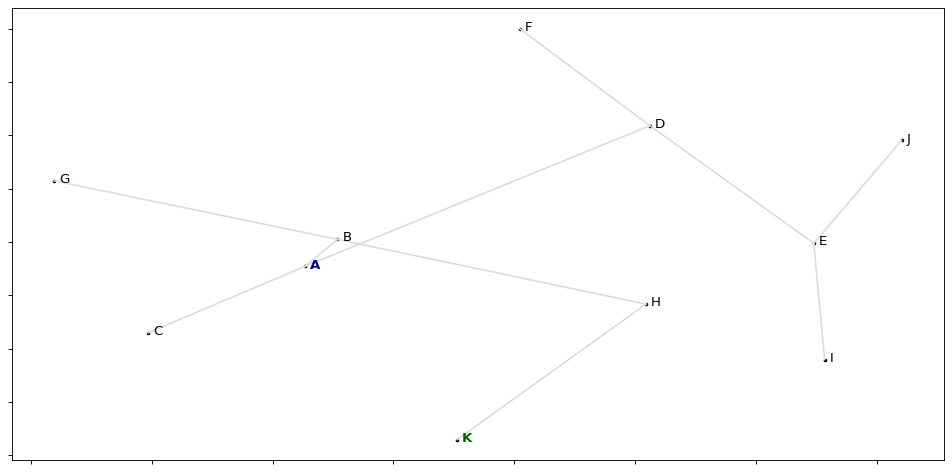


## Matriz Heurística: 
        A     B     C     D     E     F     G     H     I     J     K
  A  0.00  3.01  5.01  1.01  0.00  0.00  0.00  0.00  0.00  0.00  0.00
  B  0.02  0.00  0.00  0.00  0.00  0.00  6.01  5.01  0.00  0.00  0.00
  C  0.02  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
  D  0.02  0.00  0.00  0.00  4.01  6.01  0.00  0.00  0.00  0.00  0.00
  E  0.00  0.00  0.00  0.02  0.00  0.00  0.00  0.00  7.01  8.01  0.00
  F  0.00  0.00  0.00  0.02  0.00  0.00  0.00  0.00  0.00  0.00  0.00
  G  0.00  0.02  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
  H  0.00  0.02  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.01
  I  0.00  0.00  0.00  0.00  0.02  0.00  0.00  0.00  0.00  0.00  0.00
  J  0.00  0.00  0.00  0.00  0.02  0.00  0.00  0.00  0.00  0.00  0.00
  K  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00

## Matriz de Costo de Transiciones: 
        A     B     C     D     E     F     G     H     I     J     K
  A  0.00  0.01  0.01  0.01 

In [4]:
#@title clase ÁRBOL DE BÚSQUEDA

class ArbolBusqueda(object):

    def __init__(self, nodosHeuristicas, nodosTransiciones,
                 nodoInicial=None, nodosFinal=None,
                 mayorHeuristicaMejor=True):
        # asigna variables
        self.nodosHeuristicas = nodosHeuristicas
        self.nombreNodos = list(self.nodosHeuristicas.keys())
        self.cantNodos = len(self.nombreNodos)
        self.nodosTransiciones = nodosTransiciones
        self.mayorHeuristicaMejor = mayorHeuristicaMejor
        if (nodoInicial is None):
          # considera que el primero es el inicial
          self.idNodoInicial = 0
        else:
          # determina posición del nodo inicial
          self.idNodoInicial = self.nombreNodos.index(nodoInicial)
        if (nodosFinal is None) or (len(nodosFinal)==0):
           # considera que el último es el final
          self.IdsNodoFinal = [self.cantNodos-1]
        else:
          self.IdsNodoFinal = []
          for nf in nodosFinal:
            self.IdsNodoFinal.append( self.nombreNodos.index(nf) )
        # calcula la matriz heuristica
        self.calculaMatrizHeuristica()


    def calculaMatrizHeuristica(self):
        if (self.cantNodos==0) \
          or (len(self.nodosTransiciones)==0) \
          or (len(self.nodosHeuristicas)==0):
          return
        # inicializa la matriz con ceros
        self.matrizHeuristica = np.zeros([self.cantNodos, self.cantNodos])
        self.matrizCostos = np.zeros([self.cantNodos, self.cantNodos])
        # determina si suma o resta
        if self.mayorHeuristicaMejor:
          signoCosto = -1
        else:
          signoCosto = 1
        # calcula los valores heuristicos finales
        # para cada transición entre nodos
        # (calculado en base heuristica del nodo y costo transiciones)
        for tr in self.nodosTransiciones:
          nOr = self.nombreNodos.index( tr[0] )
          nDes = self.nombreNodos.index( tr[1] )
          if (len(tr) < 3):
            # considera un costo de 1 por defecto
            costoTr = 1
          else:
            costoTr = tr[2]
            if costoTr == 0:
              # tiene que tener un valor para poder ser considerado
              # en el recorrido
              costoTr = 0.01
          # carga transición de origen a destino
          heur = self.nodosHeuristicas[ tr[1] ] + (costoTr * signoCosto)
          if heur == 0:
            # tiene que tener un valor para poder ser considerado
            # en el recorrido
            heur = 0.01
          self.matrizCostos[nOr][nDes] = (costoTr * signoCosto)
          self.matrizHeuristica[nOr][nDes] = heur
          # si el destino no es nodo final
          if nDes not in self.IdsNodoFinal:
            # carga transición de destino a origen
            # (consideando sólo el costo pero doble)
            # para que tenga retroceso en nodos hojas
            costoTr = costoTr * 2
            self.matrizCostos[nDes][nOr] = (costoTr * signoCosto)
            self.matrizHeuristica[nDes][nOr] = (costoTr * signoCosto)
        # ajusta para que no haya valores negativos
        # (sino las hormigas se confunden para calcular probabilidades)
        minVal = np.min( self.matrizHeuristica )
        if minVal < 0:
          for i in range(self.cantNodos):
            for j in range(self.cantNodos):
              if self.matrizHeuristica[i][j] != 0:
                self.matrizHeuristica[i][j] = self.matrizHeuristica[i][j] + abs(minVal) + 0.01
        # genera posiciones XY para gráfico
        self.generarPosicionesXY()
        return


    def generarPosicionesXY(self):
        # asigna coordenadas XY para los nodos de acuerdo a la matriz de heurísticas
        #G = nx.from_numpy_matrix(self.matrizHeuristica)
        G = nx.DiGraph(np.array(self.matrizHeuristica))
        pos = nx.spring_layout(G, seed=10)
        self.posiciones = []
        for k in pos:
          self.posiciones.append( pos[k] * 10 )
        return


    def formateaIdPosicion(self, idPos):
        return self.nombreNodos[idPos]


    def formateaRecorrido(self, recIdList):
      auxRes = ""
      for id in recIdList:
        if id < 0:
          # se id negativo, como no usado
          # asi que finaliza la iteraciones
          break
        auxRes = auxRes + self.formateaIdPosicion(id)
        if id in self.IdsNodoFinal:
          auxRes = auxRes + "* "
          break
        else:
          auxRes = auxRes + " - "
      return auxRes


    def mostrarMatriz(self, matriz, titulo=""):
        print("\n"+titulo)
        cmd = pd.DataFrame(
            np.round(matriz, decimals=4),
            index=["  "+self.formateaIdPosicion(x) for x in range(self.cantNodos)],
            columns=[self.formateaIdPosicion(x) for x in range(self.cantNodos)]
          )
        # agrega para poder mostrar la matrix completa
        pd.options.display.max_rows = 100
        pd.options.display.max_columns = 100
        print(cmd)
        return


    def printInformacion(self):
        # Muestra la información sobre el ÁRBOL DE BÚSQUEDA
        # muestra gráfico con posiciones de nodos
        self.graficar(True)
        # muestra la matriz heuristica
        self.mostrarMatriz(self.matrizHeuristica, "## Matriz Heurística: ")
        # muestra la matriz de costos
        self.mostrarMatriz(self.matrizCostos, "## Matriz de Costo de Transiciones: ")
        print("\n")
        return


    # Definir posiciones de un recorrido
    def devPosicionesXYRecorrido(self, recorrido, pararEnFinal=True):
      # determina el recorrido
      coordX = []
      coordY = []
      for r in recorrido:
        if r < 0:
          # se id negativo, como no usado
          # asi que finaliza la iteraciones
          break
        pos = self.posiciones[r]
        coordX.append( pos[0] )
        coordY.append( pos[1] )
        if pararEnFinal and (r in self.IdsNodoFinal):
          # si es nodo final, no sigue generando recorrido
          break
      return coordX, coordY


    def graficar(self, mostrar=True):
      fig = plt.figure(figsize=(12,6), dpi=80)
      ax = fig.add_subplot(111)
      ax.set_xticklabels([])
      ax.set_yticklabels([])
      # muestra transicciones válidas (lo hace antes para que no tape los puntos)
      for tr in self.nodosTransiciones:
          nOr = self.nombreNodos.index(tr[0])
          nDes = self.nombreNodos.index(tr[1])
          X, Y = arbol.devPosicionesXYRecorrido( [nOr, nDes], pararEnFinal=False )
          ax.plot(X, Y, color="gainsboro") #"lightgray")
      # muesta posiciones en el gráfico
      i = 0
      for auxPos in self.posiciones:
          ax.scatter(auxPos[0], auxPos[1], color="black", s=5)
          if (i == self.idNodoInicial):
            ax.annotate(self.formateaIdPosicion(i), (auxPos[0]+0.1, auxPos[1]-0.1), color="darkblue", weight='bold', fontsize=12)
          elif (i in self.IdsNodoFinal):
            ax.annotate(self.formateaIdPosicion(i), (auxPos[0]+0.1, auxPos[1]-0.1), color="darkgreen", weight='bold', fontsize=12)
          else:
            ax.annotate(self.formateaIdPosicion(i), (auxPos[0]+0.1, auxPos[1]-0.1), fontsize=12)
          i = i + 1
      if mostrar:
        plt.tight_layout()
        plt.show()
      return fig, ax


    def calculaCostosRecorrido(self, recorrido):
        # valor inicial
        res = 0.00
        # determina en base a la matriz de costos heuristicas del recorrido
        rAnt = recorrido[0]
        for rAct in recorrido[1:]:
          if (rAnt < 0) or (rAct < 0):
            # si tienen valores negativos quiere decir que termino el recorrido
            break
          # hace sumatoria del costo
          res = res + self.matrizCostos[rAnt][rAct]
          rAnt = rAct
          if rAct in self.IdsNodoFinal:
              # si llego al nodo final
          ##    # le agrega la heurística como beneficio
          ##    heuFinal = self.nodosHeuristicas[ self.formateaIdPosicion(rAct) ]
          ##    if self.mayorHeuristicaMejor:
          ##        res = res + heuFinal
          ##    else:
          ##        res = res - heuFinal
              # y finaliza
              break
        return res


print("\nClase Árbol de Búqueda definida")

# Define el ÁRBOL DE BÚSQUEDA
arbol = ArbolBusqueda(nodosHeuristicas=nodosHeuristicas,
                    nodosTransiciones=nodosTransiciones,
                    nodoInicial=nodoInicial, nodosFinal=nodosFinal,
                    mayorHeuristicaMejor=mayorHeuristicaMejor)

print("\nÁRBOL DE BÚSQUEDA definido")

# Muestra su información
arbol.printInformacion()

In [5]:
#@title clase HORMIGAS

# clase copiada de https://github.com/guofei9987/scikit-opt/blob/dd420238b863ce8abecf3db0f5815a6602eecb1b/sko/ACA.py
# se traducen algunos comentarios y se agregan unos retoques para mejorar la visualización de los resultados
# (por ejemplo self.generation_Tau para guardar histórico de feromonas)

class ACA:
    def __init__(self, func,
                 size_pop=10, max_iter=20, max_path_ant=-1,
                 heuristic_matrix=None, bigBetter=True,
                 initNode=0, finalNode=[],
                 alpha=1, beta=2, rho=0.1
                 ):
        self.func = func # función para calcular la heurística/costo del recorrido generado
        self.size_pop = size_pop  # cantidad de hormigas
        self.max_iter = max_iter  # número de iteraciones
        self.alpha = alpha  # Importancia de las feromonas
        self.beta = beta  # La importancia de la heuristica
        self.rho = rho  # Tasa de volatilización de feromonas
        self.n_dim = len(heuristic_matrix)  # numero de nodos
        if max_path_ant <= 0:
          self.max_path_ant = self.n_dim
        else:
          self.max_path_ant = max_path_ant
        self.bigBetter = bigBetter
        self.initNode = initNode
        self.finalNode = finalNode

        # matriz de probabilidades en base a la heuristica
        self.prob_matrix_distance = heuristic_matrix / np.max(heuristic_matrix)
        if not self.bigBetter:
          # si menor más deseable calcula la probabilidad inversa
          # para los valores que no son ceros
          for i in range(self.n_dim):
            for j in range(self.n_dim):
              if self.prob_matrix_distance[i][j] != 0:
                self.prob_matrix_distance[i][j] = 1 / self.prob_matrix_distance[i][j]

        # Matriz de feromonas, actualizada cada iteración
        self.Tau = np.ones((self.n_dim, self.n_dim))
        # el camino de rastreo de cada hormiga en una determinada generación.
        self.Table = np.zeros((self.size_pop, self.max_path_ant)).astype(np.int_) - 1
        # la valoración total de rastreo de cada hormiga en una determinada generación.
        self.y = None
        # Documentando lo mejor de las generaciones.
        self.generation_best_X, self.generation_best_Y = [], []  #
        self.generation_Tau = [] # histórico de fermononas
        self.x_best_history, self.y_best_history = self.generation_best_X, self.generation_best_Y
        self.best_x, self.best_y = None, None


    def run(self, max_iter=None):
        self.max_iter = max_iter or self.max_iter
        # para cada iteración
        for i in range(self.max_iter):
            # Probabilidad de transición, sin normalización.
            prob_matrix = (self.Tau ** self.alpha) * (self.prob_matrix_distance) ** self.beta
            # reinicializa tabla por cada ciclo
            self.Table = np.zeros((self.size_pop, self.max_path_ant)).astype(np.int_) - 1
            # por cada hormiga
            for j in range(self.size_pop):
                # start point
                self.Table[j, 0] = self.initNode
                # cada nodo al que llegan las hormigas
                for k in range(self.max_path_ant-1):
                    # El punto que se ha pasado y el punto actual no se pueden volver a pasar
                    taboo_set = set(self.Table[j, :k + 1])
                    # elige entre estos puntos
                    allow_list = list(set(range(self.n_dim)) - taboo_set)
                    prob = prob_matrix[self.Table[j, k], allow_list]
                    # se fija si tiene nodos hijos para avanzar
                    if prob.sum() == 0:
                      # sino le permite elegir por nodos ya pasados
                      allow_list = list(set(range(self.n_dim)))
                      prob = prob_matrix[self.Table[j, k], allow_list]
                    if prob.sum() > 0:
                      # normalización de probabilidad
                      prob = prob / prob.sum()
                      # elige siguiente punto a avanzar
                      next_point = np.random.choice(allow_list, size=1, p=prob)[0]
                      self.Table[j, k + 1] = next_point
                    else:
                      # si no tiene a donde ir, corta las iteraciones
                      break
                    if next_point in self.finalNode:
                      # llego a uno nodo final, deja de iterar
                      break

            # Calcular valoración del recorrido (lo hace el árbol de búsqueda)
            y = np.array([self.func(i) for i in self.Table])

            # graba la mejor situación de la historia
            if self.bigBetter:
              index_best = y.argmax()
            else:
              index_best = y.argmin()
            x_best, y_best = self.Table[index_best, :].copy(), y[index_best].copy()
            self.generation_best_X.append(x_best)
            self.generation_best_Y.append(y_best)

            #  Calcular la feromona que necesita ser recién aplicada
            delta_tau = np.zeros((self.n_dim, self.n_dim))
            # cada hormiga
            for j in range(self.size_pop):
              if y[j] != 0:
                # cada nodo
                for k in range(self.max_path_ant-1):
                    # Las hormigas suben del nodo n1 al nodo n2
                    n1, n2 = self.Table[j, k], self.Table[j, k + 1]
                    if (n1 < 0) or (n2 < 0):
                        # si n1 o n2 es negativo
                        # quiere decir que no se usaron
                        # por lo que no se debe ajustar
                        break
                    # feromona a incrementar
                    if y[j] != 0:
                      delta_tau[n1, n2] += 1 / abs(y[j])

            # ajuste de feromonas
            self.Tau = (1 - self.rho) * self.Tau + delta_tau
            self.generation_Tau.append( copy.deepcopy( self.Tau ) )

        # determina meores de la corrida
        if self.bigBetter:
          best_generation = np.array(self.generation_best_Y).argmax()
        else:
          best_generation = np.array(self.generation_best_Y).argmin()
        self.best_x = self.generation_best_X[best_generation]
        self.best_y = self.generation_best_Y[best_generation]
        return self.best_x, self.best_y

    fit = run

print("Clase Hormigas ACA definida.")

Clase Hormigas ACA definida.


== Mejor Recorrido de la Corrida {0.03}: A - B - H - K*  == 



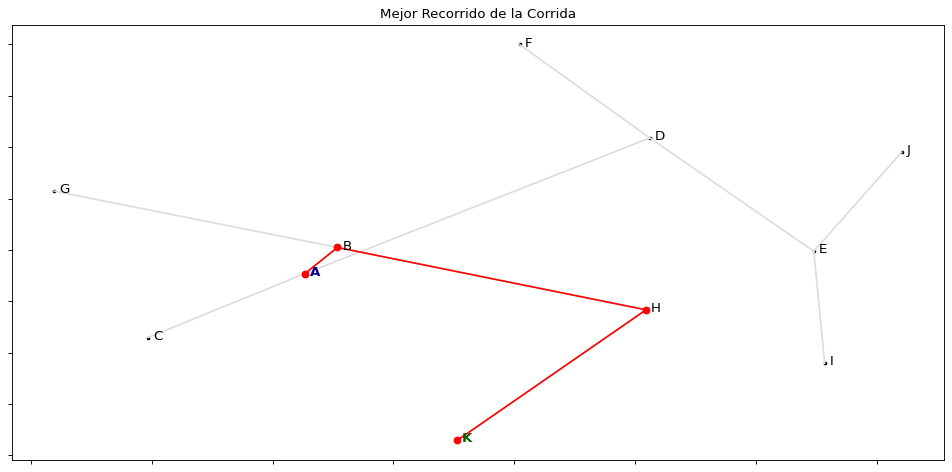




** Recorrido según Feromonas Final {0.03}: A - B - H - K*  **



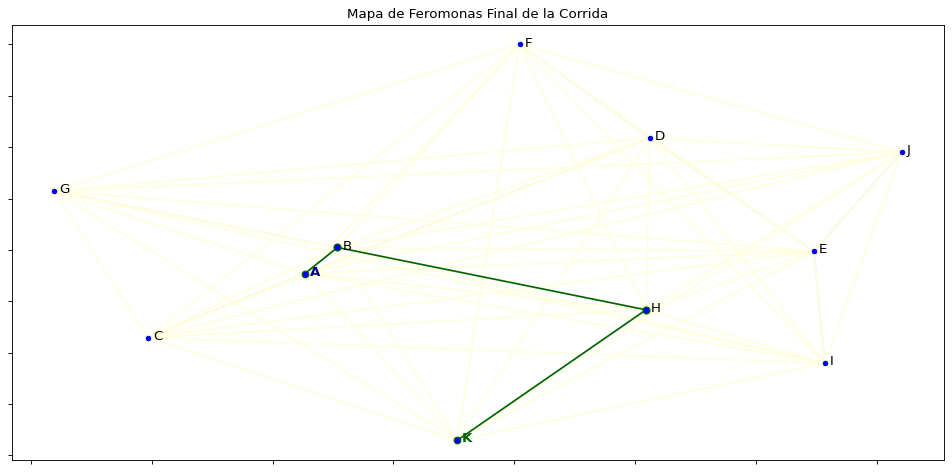


## Matriz de Feromonas Final: 
       A      B    C    D    E    F    G      H    I    J      K
  A  0.0  200.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0    0.0
  B  0.0    0.0  0.0  0.0  0.0  0.0  0.0  200.0  0.0  0.0    0.0
  C  0.0    0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0    0.0
  D  0.0    0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0    0.0
  E  0.0    0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0    0.0
  F  0.0    0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0    0.0
  G  0.0    0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0    0.0
  H  0.0    0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  200.0
  I  0.0    0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0    0.0
  J  0.0    0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0    0.0
  K  0.0    0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0    0.0


In [6]:
#@title EJECUCIÓN DE LA CORRIDA

#@markdown Parámetros del Algoritmo de Hormigas:

# Cantidad de Ciclos de la Corrida
CANT_CICLOS =  50#@param {type:"integer"}

# Configuración de las Hormigas
CANT_HORMIGAS = 3 #@param {type:"slider", min:2, max:10, step:1}
CANT_MAX_REC_HORMIGA = 50 #@param {type:"slider", min:10, max:100, step:1}

# Parámetros de Atracción
ATRACCION_FEROMONAS = 1.6 #@param {type:"slider", min:0, max:10, step:0.1}
ATRACCION_HEURISTICA = 2 #@param {type:"slider", min:0, max:10, step:0.1}
EVAPORACION_FEROMONAS = 0.5 #@param {type:"slider", min:0.1, max:1, step:0.05}

# Prepara para la corrida
aca = ACA(func = arbol.calculaCostosRecorrido,
          size_pop = CANT_HORMIGAS, max_iter = CANT_CICLOS,
          max_path_ant = CANT_MAX_REC_HORMIGA,
          heuristic_matrix = arbol.matrizHeuristica,
          bigBetter = mayorHeuristicaMejor,
          initNode = arbol.idNodoInicial,
          finalNode  = arbol.IdsNodoFinal,
          alpha = ATRACCION_FEROMONAS,
          beta = ATRACCION_HEURISTICA,
          rho = EVAPORACION_FEROMONAS)

# Ejecuta la corrida
mejorRecorrido, mejorValRecorrido = aca.run()
# nota:
#  aca.Tau: guarda el estado de las feromonas
#  aca.prob_matrix_distance: guarda las "heurísticas" de cada nodo de acuerdo a la matriz de distancia
msgMejor = "== Mejor Recorrido de la Corrida {" + str(round(mejorValRecorrido, 3)) + "}: "+ str(arbol.formateaRecorrido(mejorRecorrido)) + " =="
print(msgMejor, "\n")

# Muesta el gráfico del Mejor Recorrido
fig, ax = arbol.graficar(mostrar=False)
# determina el recorrido
# Determina las coordenadas x, y de las posiciones en el mejor recorrido
X, Y = arbol.devPosicionesXYRecorrido( mejorRecorrido )
# muesta el recorrido
ax.plot(X, Y, 'o-r')
ax.set_title("Mejor Recorrido de la Corrida")
plt.tight_layout()
plt.show()

# Muestra el Gráfico de Matriz de Feromonas Final
print("\n")
# método que se usa para generar gradiente de colores
def colorFader(c1, c2, mix=0.0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1 = np.array(mpl.colors.to_rgb(c1))
    c2 = np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

def mostrarFeromonas(axFer, matFeromonas):
    auxVecFer = []
    maxFer = np.max(matFeromonas)
    # determina valor relativo a mostrar
    for p1 in range(arbol.cantNodos):
      for p2 in range(arbol.cantNodos):
        if p1 < p2:
            valRel = max(matFeromonas[p1][p2], matFeromonas[p2][p1]) / maxFer
            X, Y = arbol.devPosicionesXYRecorrido( [p1, p2], pararEnFinal=False )
            auxVecFer.append( [valRel, X, Y] )
    # ordena de menor a mayor para que se vean mejor las líneas con gran valor
    auxVecFer = sorted(auxVecFer, key=lambda k: k[0], reverse=False)
    # muestra las líneas de feromonas
    for vFer in auxVecFer:
      c = colorFader('lightyellow', 'darkgreen', vFer[0])
      lineFer = axFer.plot(vFer[1], vFer[2],
                  marker='o', markerfacecolor='b', color=c, linestyle='-')
    return


# calcula el recorrido según feromonas
def recorridoFeromonas(matTau):
    p = 0
    rec_list = [0]
    while True:
      p = np.argmax(matTau[p])
      rec_list.append( p )
      if p in arbol.IdsNodoFinal:
        break
    rec_list = np.array(rec_list)
    dist = arbol.calculaCostosRecorrido( rec_list )
    return rec_list, dist

fer_rec, fer_dist = recorridoFeromonas(aca.Tau)
print("\n** Recorrido según Feromonas Final {" + str(round(fer_dist, 3)) + "}: "+ str(arbol.formateaRecorrido(fer_rec)) + " **\n" )

figFer, axFer = arbol.graficar(mostrar=False)
axFer.set_title("Mapa de Feromonas Final de la Corrida")
mostrarFeromonas(axFer, aca.Tau)
plt.tight_layout()
plt.show()
arbol.mostrarMatriz(aca.Tau, "## Matriz de Feromonas Final: ")


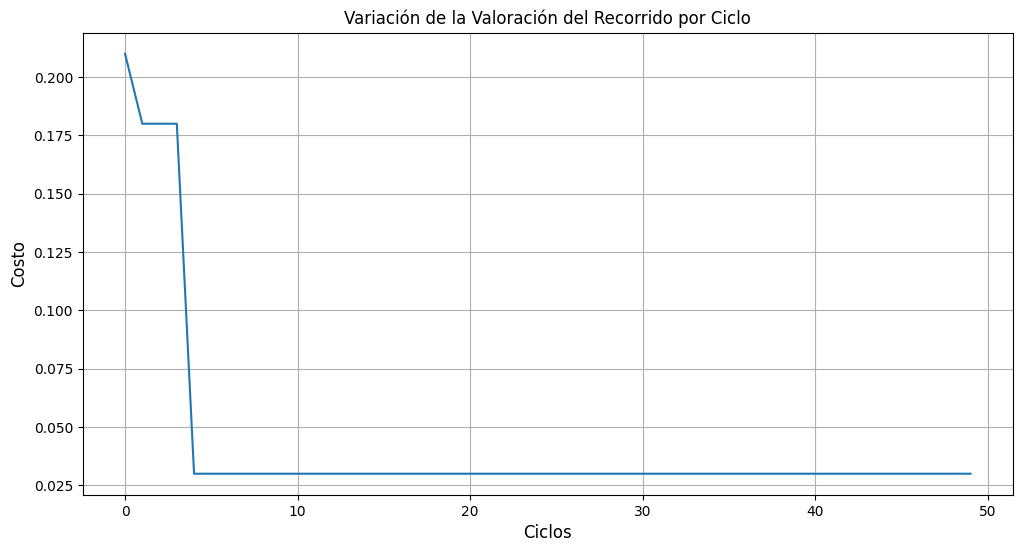

In [7]:
#@title MOSTRAR VARIACIÓN DEL COSTO DEL RECORRIDO
plt.figure(figsize=(12,6))
plt.plot(aca.y_best_history)
plt.title('Variación de la Valoración del Recorrido por Ciclo')
plt.xlabel('Ciclos', fontsize=12)
plt.ylabel('Costo', fontsize=12)
plt.grid(True)
plt.show()

In [8]:
#@title MOSTRAR GRAFICO MEJOR RECORRIDO + FEROMINAS POR CADA CICLO

# Librerías especiales para usar
from matplotlib import animation, rc
from IPython.display import HTML

# inicializa variables auxiliares
recCiclo = aca.x_best_history
distCiclo = aca.y_best_history
matFeromonasCiclo = aca.generation_Tau

# Método que se ejecuta por cada frame para mostrar
def updatePlot(i):
    i = i - 1 # le resta 1 para que arranque vacío
    if i < 0:
        axFer.set_xlabel("Ciclo: 0", fontsize=12)
        # muestra gráfico de feromonas inicial
        lineFer = mostrarFeromonas(axFer, matFeromonasCiclo[0])
    else:
      # muestra gráfico de feromonas actual
      if i<len(matFeromonasCiclo):
        lineFer = mostrarFeromonas(axFer, matFeromonasCiclo[i])
      # muestra gráfico de recorrido actual
      if i<len(recCiclo):
        distMostrar = str(round(distCiclo[i], 3))
        if distCiclo[i] == mejorValRecorrido:
          distMostrar = distMostrar + "!"
          colorLineRec = 'r'
        else:
          colorLineRec = 'c'
        axFer.set_xlabel("Ciclo: " + str(i+1) + " -  Costo Recorrido: " + distMostrar, fontsize=12)
        # Determina las coordenadas x, y del recorrido 'i'
        X, Y = arbol.devPosicionesXYRecorrido( recCiclo[i] )
        plt.setp(lineRec, 'xdata', X, 'ydata', Y)
        plt.setp(lineRec, 'color', colorLineRec)
      else:
        axFer.set_xlabel("Ciclo: " + str(i+1), fontsize=12)
    return lineRec

def prepararAxFig(nfig, posSubPlot=111):
  # prepara el gráfico base (puntos)
  figBase, axBase = arbol.graficar(mostrar=False)
  plt.close(figBase)
  # cambia la figura del ax
  ax = axBase
  ax.figure = nfig
  nfig.axes.append(ax)
  nfig.add_axes(ax)
  dummy_ax = nfig.add_subplot(posSubPlot)
  ax.set_position(dummy_ax.get_position())
  dummy_ax.remove()
  return ax

# prepara gráfico para animación
fig = plt.figure(figsize=(12,6), dpi=80)
# indica gráfico para recorrido
axRec = prepararAxFig(fig, 211)
axRec.set_xticklabels([])
# segundo gráfico para feromonas
axFer = prepararAxFig(fig, 212)
plt.close(fig)
plt.close(fig)

# Determina las coordenadas x, y de las posiciones en el recorrido inicial
# (las marca en blanco para que no se vean)
X, Y = arbol.devPosicionesXYRecorrido( recCiclo[0] )
lineRec = axRec.plot(X, Y,
            marker='o', markerfacecolor='b', color='gainsboro', linestyle='-')
lineFer = []
# Muestra título y texto debajo
axRec.set_title("Mejor Recorrido por Ciclo")
axFer.set_title("Mapa de Fermonas por Ciclo")

# Luego setea la animación usando los dos métodos anteriores
cant = len(recCiclo)+1  # le suma 1 porque arranca vacío
ani = animation.FuncAnimation(fig, updatePlot,
                              frames=cant, interval=cant,
                              blit=True, repeat=False)

# Nota: esto se agega para que funcione en Google Colab
rc('animation', html='jshtml')
display(ani)

print("\n", msgMejor)

Output hidden; open in https://colab.research.google.com to view.